In [1]:
import os
from pathlib import Path

def is_kaggle_kernel():
    return os.path.exists('/kaggle/working')

if is_kaggle_kernel():

    BASE_DIR = Path("/kaggle")
    DATA_DIR = BASE_DIR / "input"
    OUTPUT_DIR = BASE_DIR / "working"
    print('on kaggle notebook')

else:
    BASE_DIR = Path(os.getcwd()) / './../'
    DATA_DIR = BASE_DIR / "data"
    OUTPUT_DIR = BASE_DIR / "output/eda"
    
class paths:    
    DATA_DIR = DATA_DIR
    TRAIN_PATH = DATA_DIR / "train.parquet"
    TEST_PATH = DATA_DIR / "test.parquet"
    OUTPUT_DIR = OUTPUT_DIR
    SHRUNKEN_DATA_DIR = DATA_DIR / "shrunken-train-set"
    
    OUTPUT_DIR.mkdir(exist_ok=True, parents=True)

In [103]:
import os
import gc
import math
import numpy as np
import pandas as pd
from glob import glob
import duckdb
import lightgbm as lgb

from rdkit import Chem
from rdkit.Chem import Draw

import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from rdkit.Chem.Scaffolds import MurckoScaffold

import pickle

In [3]:
bb_cols = ['buildingblock1_smiles', 'buildingblock2_smiles','buildingblock3_smiles', 'molecule_smiles']
TARGETS = ['binds_BRD4', 'binds_HSA','binds_sEH']

df_train = pd.read_parquet(paths.DATA_DIR / 'shrunken-train-set/train.parquet', columns=bb_cols + TARGETS)
df_test = pd.read_parquet(paths.DATA_DIR / 'shrunken-train-set/test.parquet', columns=bb_cols)

# building block smiles
# NOTE: trainとtestのindexとsmilesは一致していないっぽい
with open(paths.SHRUNKEN_DATA_DIR / 'train_dicts/BBs_dict_reverse_1.p', 'rb') as file:
    train_dicts_bb1 = pickle.load(file)
with open(paths.SHRUNKEN_DATA_DIR / 'train_dicts/BBs_dict_reverse_2.p', 'rb') as file:
    train_dicts_bb2 = pickle.load(file)
with open(paths.SHRUNKEN_DATA_DIR / 'train_dicts/BBs_dict_reverse_3.p', 'rb') as file:
    train_dicts_bb3 = pickle.load(file)

with open(paths.SHRUNKEN_DATA_DIR / 'test_dicts/BBs_dict_reverse_1_test.p', 'rb') as file:
    test_dicts_bb1 = pickle.load(file)
with open(paths.SHRUNKEN_DATA_DIR / 'test_dicts/BBs_dict_reverse_2_test.p', 'rb') as file:
    test_dicts_bb2 = pickle.load(file)
with open(paths.SHRUNKEN_DATA_DIR / 'test_dicts/BBs_dict_reverse_3_test.p', 'rb') as file:
    test_dicts_bb3= pickle.load(file)
    
test_dicts_bb1_reverse = {val:key for key, val in test_dicts_bb1.items()}
test_dicts_bb2_reverse = {val:key for key, val in test_dicts_bb2.items()}
test_dicts_bb3_reverse = {val:key for key, val in test_dicts_bb3.items()}

ArrowInvalid: No match for FieldRef.Name(binds_BRD4) in buildingblock1_smiles: int16
buildingblock2_smiles: int16
buildingblock3_smiles: int16
molecule_smiles: string
is_BRD4: bool
is_HSA: bool
is_sEH: bool
__fragment_index: int32
__batch_index: int32
__last_in_fragment: bool
__filename: string

In [7]:
bb1_smiles_train = [smiles for smiles in train_dicts_bb1.values()]
bb2_smiles_train = [smiles for smiles in train_dicts_bb2.values()]
bb3_smiles_train = [smiles for smiles in train_dicts_bb3.values()]
bb1_smiles_test = [smiles for smiles in test_dicts_bb1.values()]
bb2_smiles_test = [smiles for smiles in test_dicts_bb2.values()]
bb3_smiles_test = [smiles for smiles in test_dicts_bb3.values()]

bb1_mols_train = [Chem.MolFromSmiles(smiles) for smiles in bb1_smiles_train]
bb2_mols_train = [Chem.MolFromSmiles(smiles) for smiles in bb2_smiles_train]
bb3_mols_train = [Chem.MolFromSmiles(smiles) for smiles in bb3_smiles_train]
bb1_mols_test = [Chem.MolFromSmiles(smiles) for smiles in bb1_smiles_test]
bb2_mols_test = [Chem.MolFromSmiles(smiles) for smiles in bb2_smiles_test]
bb3_mols_test = [Chem.MolFromSmiles(smiles) for smiles in bb3_smiles_test]

## 分子見る
root molecule（bb1）がtriazineを反映しているかcheck

In [8]:
# share
bb1_smiles_test_share = set(bb1_smiles_test) & set(bb1_smiles_train)
bb1_mols_test_share = [Chem.MolFromSmiles(smiles) for smiles in bb1_smiles_test_share]
print(len(bb1_smiles_test_share))

# not share
bb1_smiles_test_no_share = set(bb1_smiles_test) - set(bb1_smiles_train)
bb1_mols_test_no_share = [Chem.MolFromSmiles(smiles) for smiles in bb1_smiles_test_no_share]
print(len(bb1_smiles_test_no_share))

271
70


/usr/local/lib/python3.10/site-packages/rdkit/Chem/Draw/IPythonConsole.py:258: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  warnings.warn(


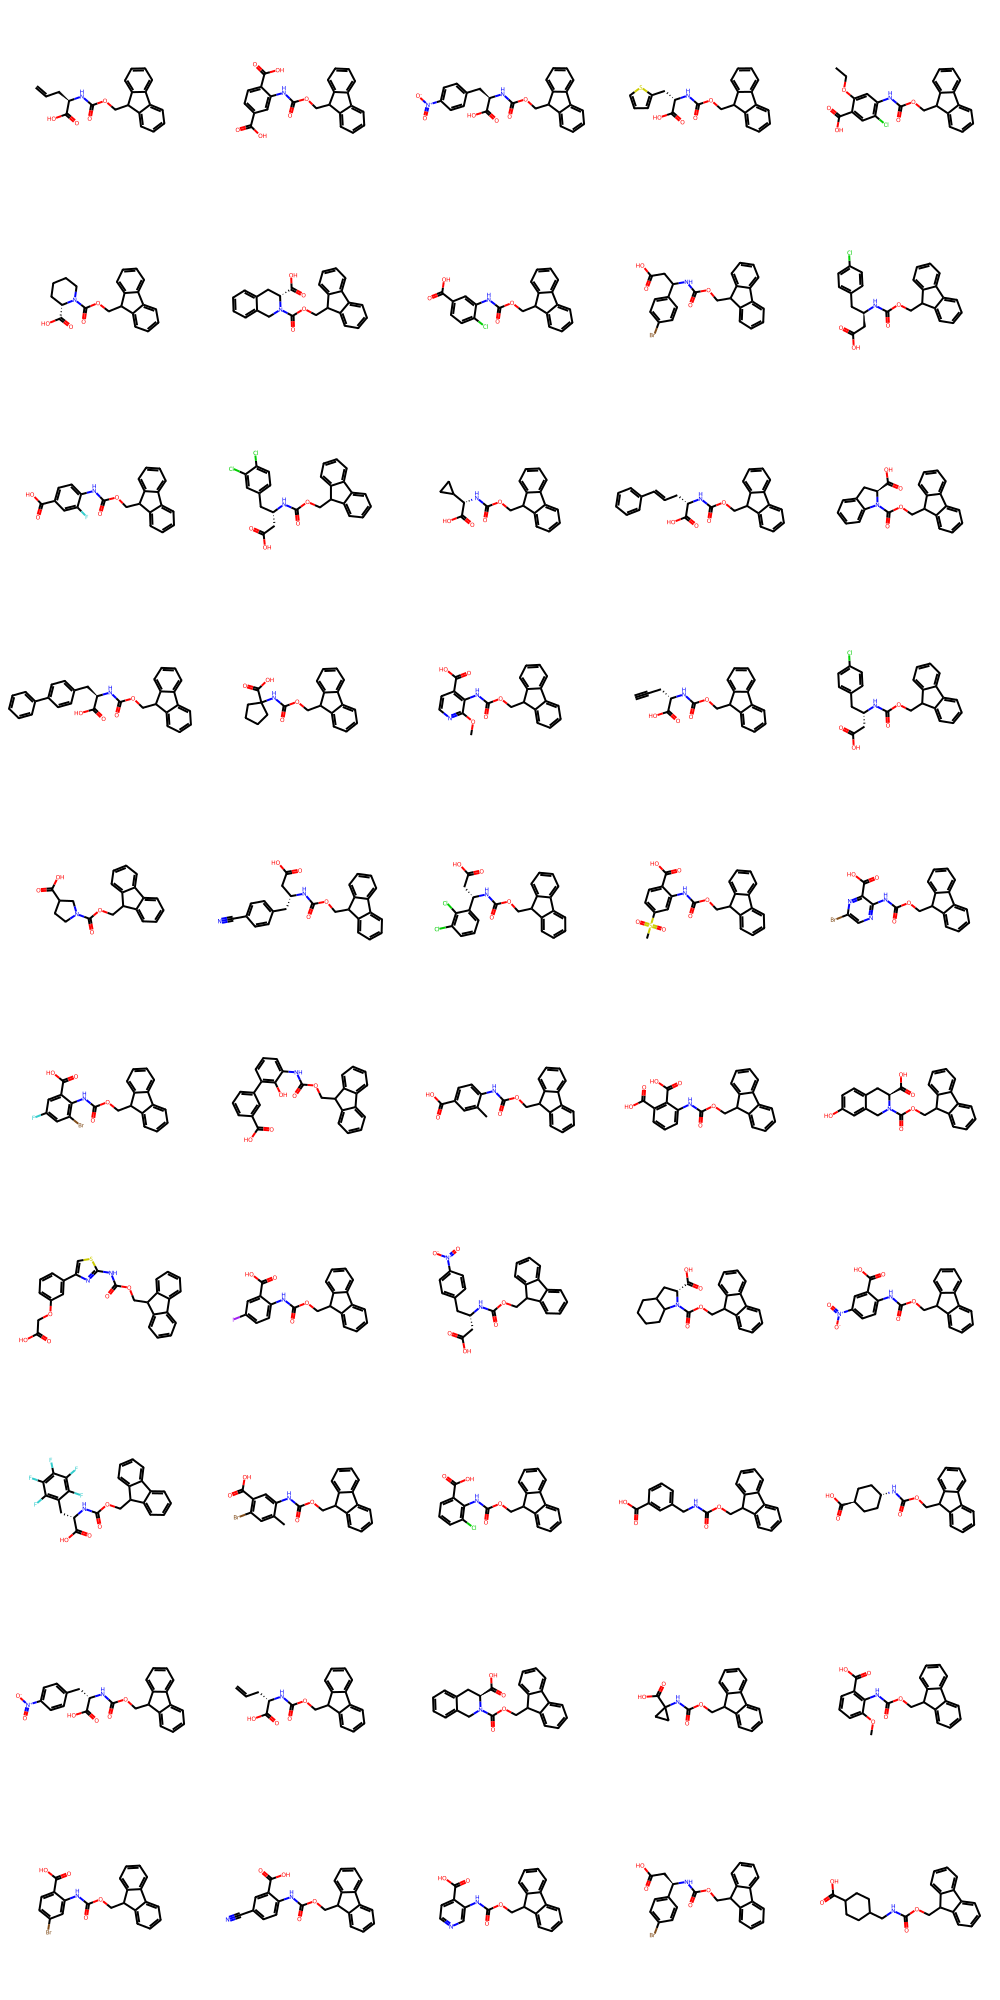

In [9]:
img = Draw.MolsToGridImage(bb1_mols_test_share,
                            molsPerRow=5, #一列に配置する分子の数
                            subImgSize=(200,200),
                            )
img

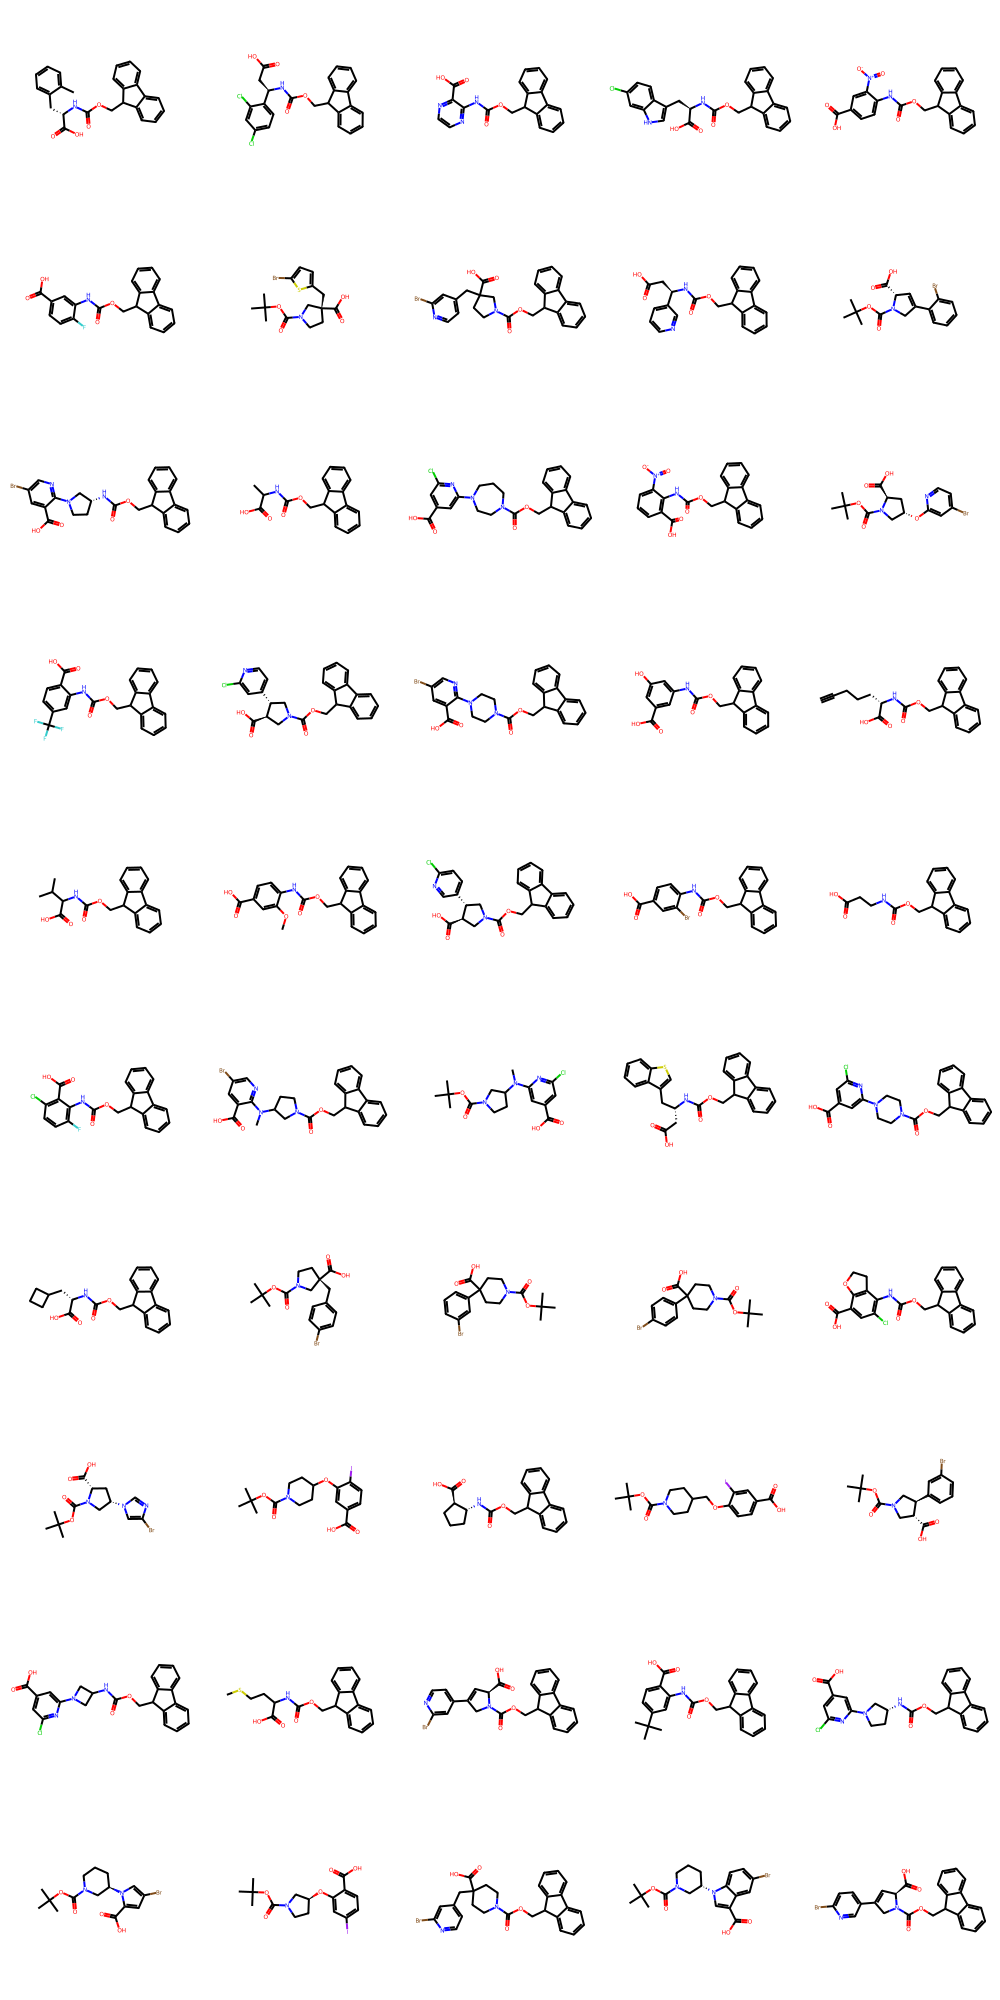

In [10]:
img = Draw.MolsToGridImage(bb1_mols_test_no_share,
                            molsPerRow=5, #一列に配置する分子の数
                            subImgSize=(200,200),
                            )
img

In [23]:
# bb1がshareしている分子のsmiles
bb1_idx_test_share = [test_dicts_bb1_reverse[smiles] for smiles in bb1_smiles_test_share]
bb1_idx_test_no_share = [test_dicts_bb1_reverse[smiles] for smiles in bb1_smiles_test_no_share]

df_test_share = df_test.query("buildingblock1_smiles in @bb1_idx_test_share")
df_test_no_share = df_test.query("buildingblock1_smiles in @bb1_idx_test_no_share")


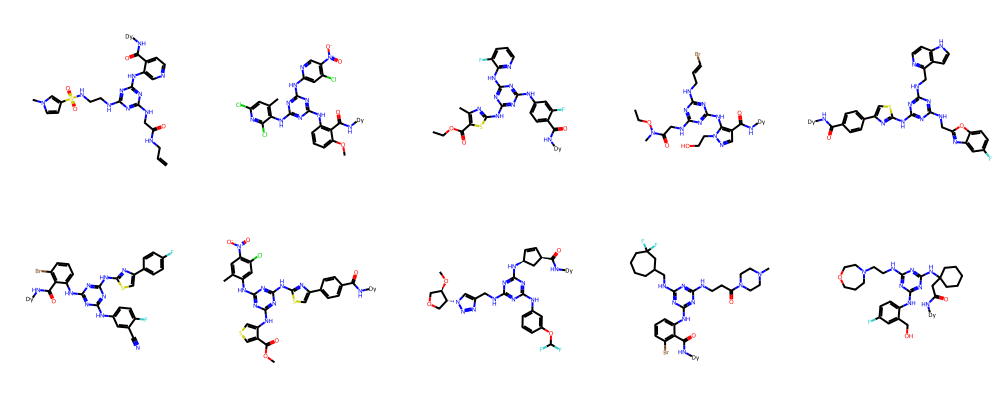

In [108]:
temp = df_test_share.sample(10)
mol_share = [Chem.MolFromSmiles(s) for s in temp['molecule_smiles']]

img = Draw.MolsToGridImage(mol_share,
                            molsPerRow=5, #一列に配置する分子の数
                            subImgSize=(200,200),
                            )
img

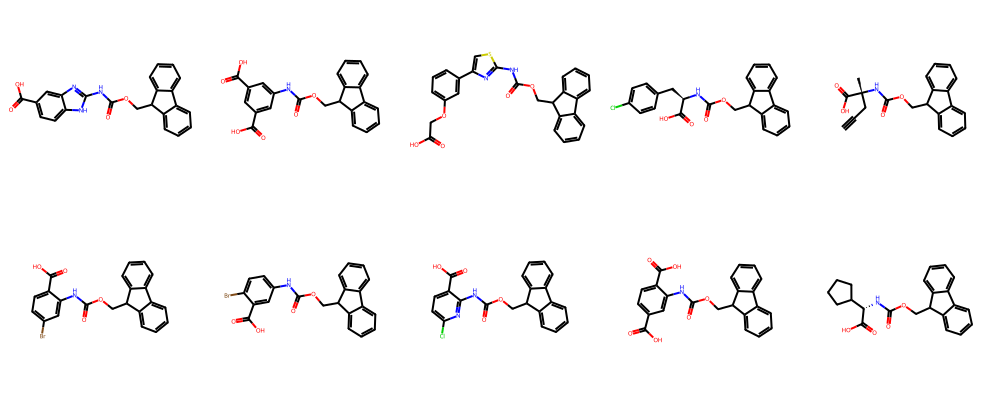

In [90]:
mol_bb1 = [Chem.MolFromSmiles(test_dicts_bb1[s]) for s in temp['buildingblock1_smiles']]
img = Draw.MolsToGridImage(mol_bb1,
                            molsPerRow=5, #一列に配置する分子の数
                            subImgSize=(200,200),
                            )
img

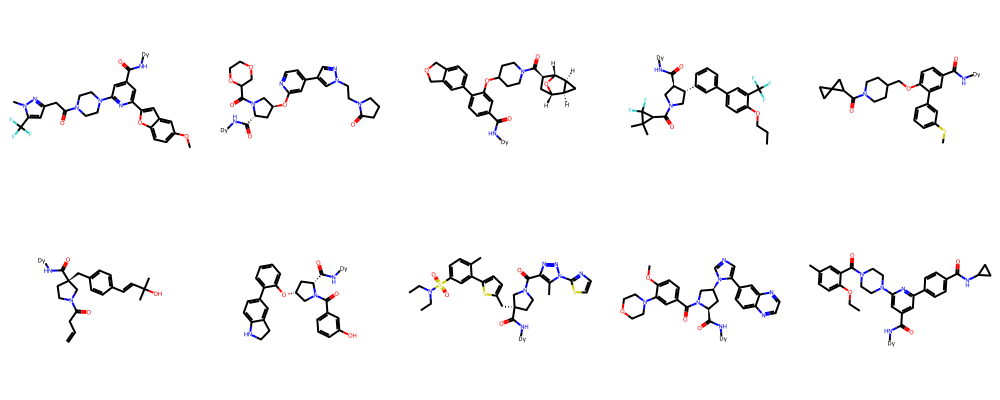

In [111]:
temp = df_test_no_share.sample(10)
mol_no_share = [Chem.MolFromSmiles(s) for s in temp['molecule_smiles']]
mol_bb1 = [Chem.MolFromSmiles(test_dicts_bb1[s]) for s in temp['buildingblock1_smiles']]

# mol_no_share = [MurckoScaffold.GetScaffoldForMol(mol) for mol in mol_no_share]
img = Draw.MolsToGridImage(mol_no_share,
                            molsPerRow=5, #一列に配置する分子の数
                            subImgSize=(200,200),
                            )
img


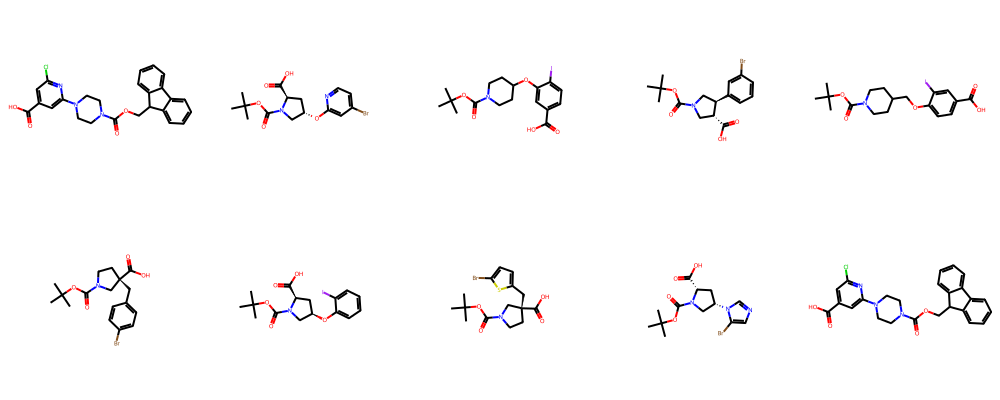

In [112]:
img = Draw.MolsToGridImage(mol_bb1,
                            molsPerRow=5, #一列に配置する分子の数
                            subImgSize=(200,200),
                            )
img

## murcko scaffold

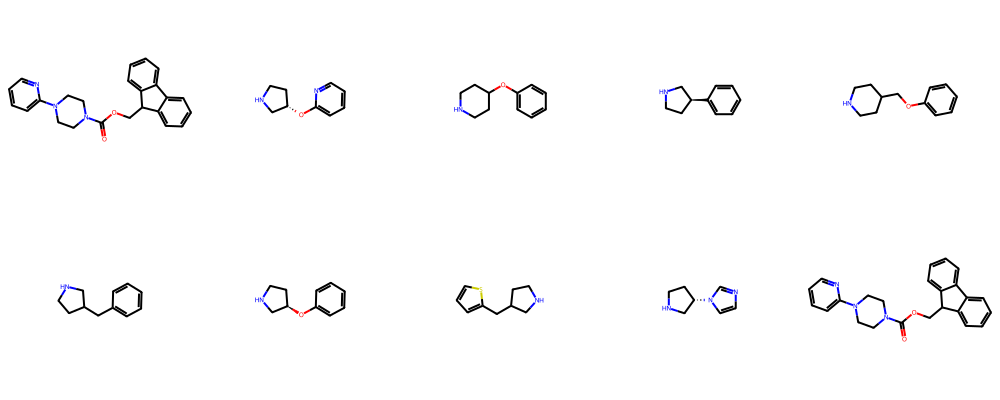

In [113]:
from rdkit.Chem.Scaffolds import MurckoScaffold
core = [MurckoScaffold.GetScaffoldForMol(mol) for mol in mol_bb1]
img = Draw.MolsToGridImage(core,
                            molsPerRow=5, #一列に配置する分子の数
                            subImgSize=(200,200),
                            )
img

## 分子をscaffoldごとにクラスタリングできるか

In [133]:
# bb1のscaffoldを取得
from tqdm import tqdm

scaffold_dict = {}
for smiles in tqdm(bb1_smiles_train):
    mol = Chem.MolFromSmiles(smiles)
    scaffold = MurckoScaffold.GetScaffoldForMol(mol)
    scaffold_smiles = Chem.MolToSmiles(scaffold)
    
    scaffold_dict[smiles] = scaffold_smiles

100%|██████████| 271/271 [00:00<00:00, 5314.06it/s]


{'C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21': 'c1ccc2c(c1)Cc1ccccc1-2',
 'C#CC[C@@H](NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O': 'c1ccc2c(c1)Cc1ccccc1-2',
 'C#CC[C@@](C)(NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O': 'c1ccc2c(c1)Cc1ccccc1-2',
 'C#CC[C@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21': 'c1ccc2c(c1)Cc1ccccc1-2',
 'C#CC[C@H](NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O': 'c1ccc2c(c1)Cc1ccccc1-2',
 'C=CCC(CC=C)(NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O': 'c1ccc2c(c1)Cc1ccccc1-2',
 'C=CCC(NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O': 'c1ccc2c(c1)Cc1ccccc1-2',
 'C=CCC[C@@H](NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O': 'c1ccc2c(c1)Cc1ccccc1-2',
 'C=CC[C@@H](NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O': 'c1ccc2c(c1)Cc1ccccc1-2',
 'C=CC[C@H](NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O': 'c1ccc2c(c1)Cc1ccccc1-2',
 'CC(=O)c1ccc(C[C@H](NC(=O)OCC2c3ccccc3-c3ccccc32)C(=O)O)cc1': 'O=C(NCCc1ccccc1)OCC1c2ccccc2-c2ccccc21',
 'CC(C)(C)OC(=O)CC(NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O': 'c1ccc2c(c1)Cc1ccccc1-2',
 'CC(C)(C)OC(=O)CCC(NC(=O)OCC1c2ccccc2-c2ccc

In [132]:
len(set(scaffold_list))

63

# EDA

In [3]:
TEMP = paths.DATA_DIR / 'belka-cv-split'
train_fold = pd.read_parquet(TEMP / 'train_folds.parquet')

In [35]:
test = pd.read_parquet(TEMP / 'test.parquet')

with open(TEMP / 'bbdict.pickle', 'rb') as f:
    bbdict = pickle.load(f)
with open(TEMP / 'bbdict-test.pickle', 'rb') as f:
    bbdict_test = pickle.load(f)

len(bbdict_test)

2110

In [36]:
bbdict_test

{'Nc1ccc(Cl)c(C(F)(F)F)c1': 0,
 'N#Cc1cncnc1N': 1,
 'Nc1ncnc2[nH]ncc12': 2,
 'Cc1nn(C2CCOCC2)cc1C(=O)O': 3,
 'CC(F)(F)c1cccc(B2OC(C)(C)C(C)(C)O2)c1': 4,
 'COc1cc(CN)sn1.Cl.Cl': 5,
 'NCC1(N2CCOCC2)CC1': 6,
 'O=C(O)c1cccc(N2CCOCC2=O)c1': 7,
 'Nc1ccc(-n2cncn2)cc1': 8,
 'CC(C)CC(C)(CN)NC(=O)c1cc(Cl)c(Cl)[nH]1.Cl': 9,
 'O=C(O)c1ccn(COc2ccccc2)n1': 10,
 'CC(C)CC(NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O': 11,
 'COC(=O)c1ccc(N)cc1O': 12,
 'COC(=O)c1scnc1N': 13,
 'COc1ccc(CN)cc1CN1CCOCC1.Cl.Cl': 14,
 'O=C(O)[C@@]12COC[C@@H]1C2': 15,
 'Nc1c(F)cccc1F': 16,
 'Nc1nc(C2CC2)cs1': 17,
 'COc1cc(B(O)O)c(F)cn1': 18,
 'COc1ccc(N)c(Cl)c1': 19,
 'CC1(C)OB(c2ccc(N3CCOCC3)nc2)OC1(C)C': 20,
 'COC1(C(=O)O)CC1': 21,
 'CC1(C)OB(O)c2ccccc21': 22,
 'Cc1nc(Cl)c(N)c(Cl)n1': 23,
 'CC(C)(C)OC(=O)n1ncc2cc(N)ccc21': 24,
 'O=C(O)c1cnn(C2CC2(F)F)c1': 25,
 'COc1cc(C(=O)O)ccc1NC(=O)OCC1c2ccccc2-c2ccccc21': 26,
 'Cc1cnc(Cl)cc1N': 27,
 'COc1cc(NC(=O)OCC2c3ccccc3-c3ccccc32)c(C(=O)O)c(OC)c1': 28,
 'Nc1nc2ccccc2s1': 29,
 'COc1cncc(N)n

# import data

In [15]:
con = duckdb.connect()

In [16]:
sample = con.query(f"""(SELECT * FROM parquet_scan('{paths.TRAIN_PATH}') LIMIT 10)""").df()
sample.head()

,id,buildingblock1_smiles,buildingblock2_smiles,buildingblock3_smiles,molecule_smiles,protein_name,binds
0,0,C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21,C#CCOc1ccc(CN)cc1.Cl,Br.Br.NCC1CCCN1c1cccnn1,C#CCOc1ccc(CNc2nc(NCC3CCCN3c3cccnn3)nc(N[C@@H]...,BRD4,0
1,1,C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21,C#CCOc1ccc(CN)cc1.Cl,Br.Br.NCC1CCCN1c1cccnn1,C#CCOc1ccc(CNc2nc(NCC3CCCN3c3cccnn3)nc(N[C@@H]...,HSA,0
2,2,C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21,C#CCOc1ccc(CN)cc1.Cl,Br.Br.NCC1CCCN1c1cccnn1,C#CCOc1ccc(CNc2nc(NCC3CCCN3c3cccnn3)nc(N[C@@H]...,sEH,0
3,3,C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21,C#CCOc1ccc(CN)cc1.Cl,Br.NCc1cccc(Br)n1,C#CCOc1ccc(CNc2nc(NCc3cccc(Br)n3)nc(N[C@@H](CC...,BRD4,0
4,4,C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21,C#CCOc1ccc(CN)cc1.Cl,Br.NCc1cccc(Br)n1,C#CCOc1ccc(CNc2nc(NCc3cccc(Br)n3)nc(N[C@@H](CC...,HSA,0


In [17]:
# train test building block
# buildingblock1 smiles
def get_buildingblock1_smiles_stats(col, path):
    qyery = f"""
        (SELECT distinct {col} FROM parquet_scan('{path}'))
        """
    df = con.query(qyery).df()
    
    return df[col].values.tolist()


smiles_b1_train = get_buildingblock1_smiles_stats('buildingblock1_smiles', paths.TRAIN_PATH)
smiles_b2_train = get_buildingblock1_smiles_stats('buildingblock2_smiles', paths.TRAIN_PATH)
smiles_b3_train = get_buildingblock1_smiles_stats('buildingblock3_smiles', paths.TRAIN_PATH)
smiles_b1_test = get_buildingblock1_smiles_stats('buildingblock1_smiles', paths.TEST_PATH)
smiles_b2_test = get_buildingblock1_smiles_stats('buildingblock2_smiles', paths.TEST_PATH)
smiles_b3_test = get_buildingblock1_smiles_stats('buildingblock3_smiles', paths.TEST_PATH)

print(f"smiles_b1_train: {len(smiles_b1_train)}")
print(f"smiles_b2_train: {len(smiles_b2_train)}")
print(f"smiles_b3_train: {len(smiles_b3_train)}")
print(f"smiles_b1_test: {len(smiles_b1_test)}")
print(f"smiles_b2_test: {len(smiles_b2_test)}")
print(f"smiles_b3_test: {len(smiles_b3_test)}")


smiles_b1_train: 271
smiles_b2_train: 693
smiles_b3_train: 872
smiles_b1_test: 341
smiles_b2_test: 1140
smiles_b3_test: 1389


In [18]:
# 共通部分を調べる
# >>> test dataのbuilding blockはtrain dataのbuilding blockをカバーしている。
# >>> test dataは外挿予測になる
print(len(set(smiles_b1_train) & set(smiles_b1_test)))
print(len(set(smiles_b2_train) & set(smiles_b2_test)))
print(len(set(smiles_b3_train) & set(smiles_b3_test)))

271
693
871


In [24]:
# 全molecule
all_mol_train = list(set(smiles_b1_train) | set(smiles_b2_train) | set(smiles_b3_train))
all_mol_test = list(set(smiles_b1_test) | set(smiles_b2_test) | set(smiles_b3_test))

print(len(all_mol_train))
print(len(all_mol_test))


1145
2110


271


/usr/local/lib/python3.10/site-packages/rdkit/Chem/Draw/IPythonConsole.py:258: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  warnings.warn(


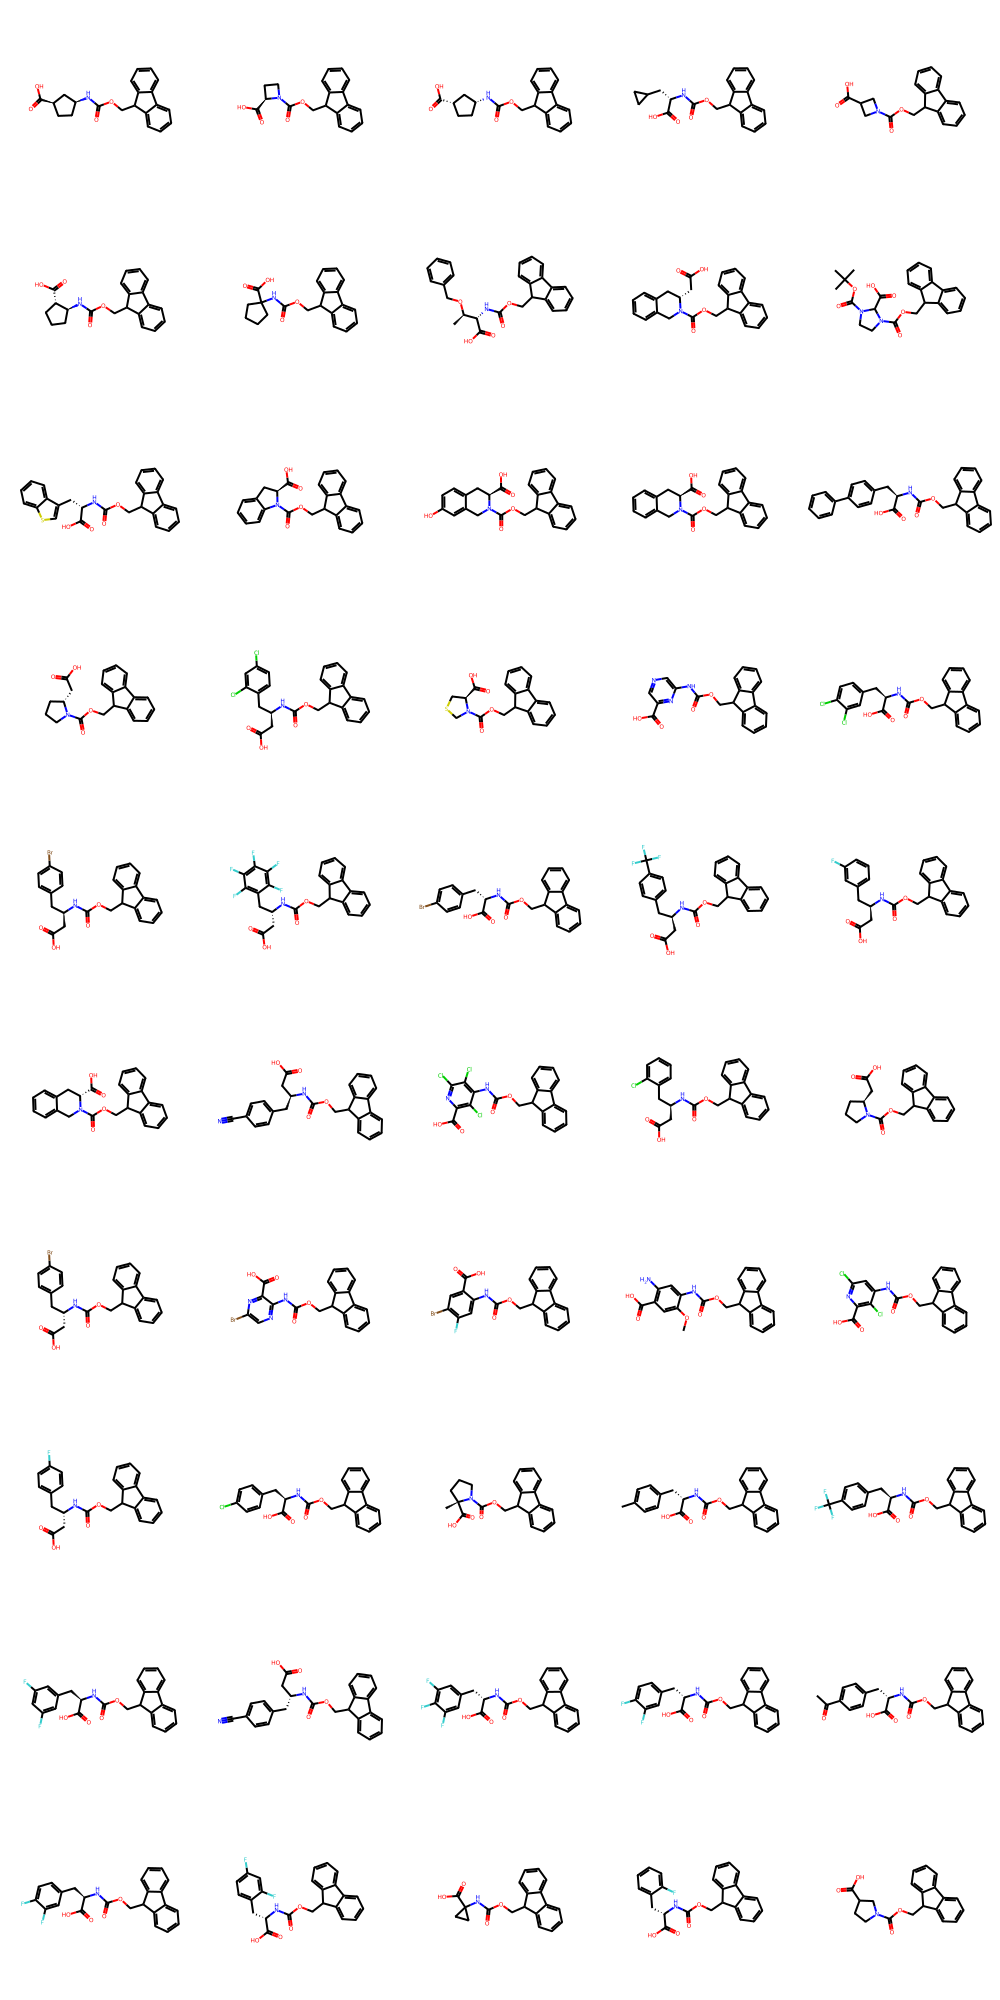

In [8]:
# buildingblock1 smiles
qyery = f"""
        (SELECT buildingblock1_smiles, count(*) as buildingblock1_smiles_count 
        FROM parquet_scan('{paths.TRAIN_PATH}') GROUP BY buildingblock1_smiles ORDER BY count(*) DESC)
        """
buildingblock1_smiles_stats = con.query(qyery).df()
smiles_list_b1 = buildingblock1_smiles_stats['buildingblock1_smiles'].values.tolist()
mols_list_b1 = [Chem.MolFromSmiles(s) for s in smiles_list_b1]
print(len(mols_list_b1))

img = Draw.MolsToGridImage(mols_list_b1,
molsPerRow=5, #一列に配置する分子の数
subImgSize=(200,200),
)
img

693


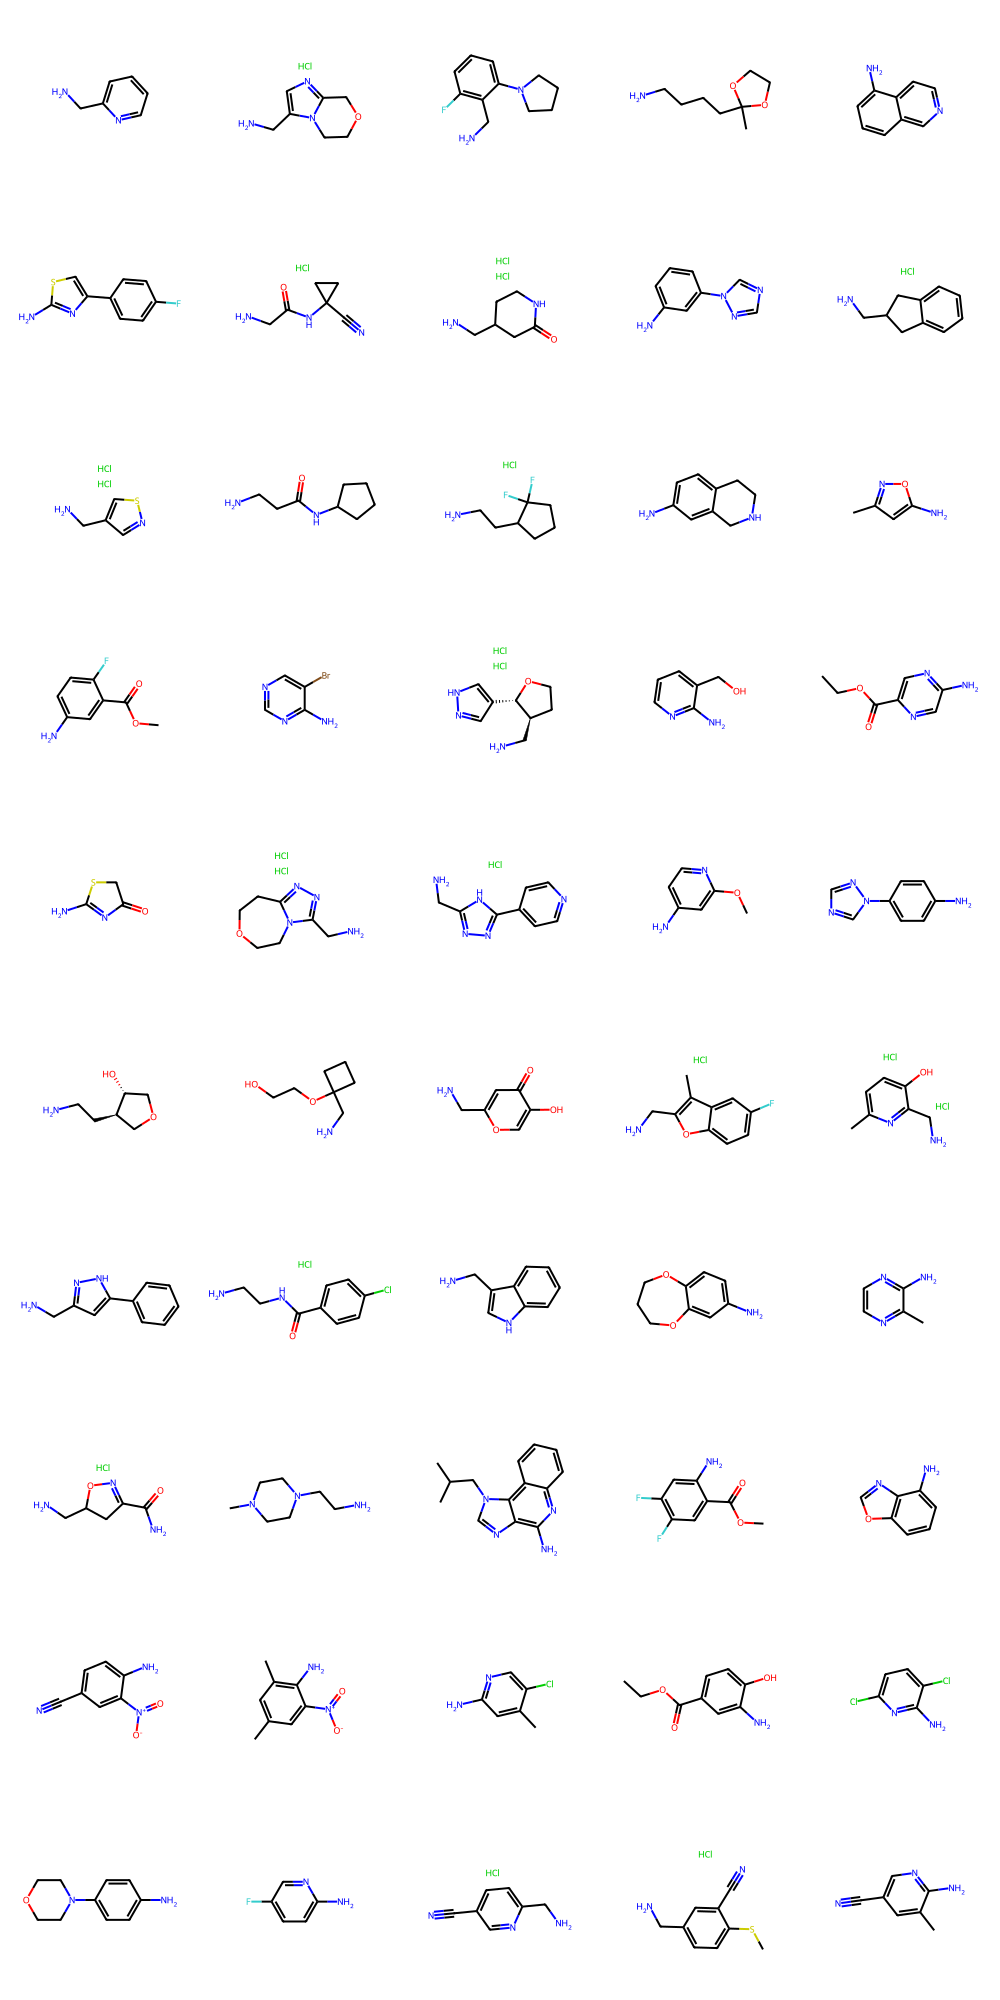

In [9]:
# buildingblock1 smiles
qyery = f"""
        (SELECT buildingblock2_smiles, count(*) as buildingblock2_smiles_count 
        FROM parquet_scan('{paths.TRAIN_PATH}') GROUP BY buildingblock2_smiles ORDER BY count(*) DESC)
        """
buildingblock2_smiles_stats = con.query(qyery).df()
smiles_list_b2 = buildingblock2_smiles_stats['buildingblock2_smiles'].values.tolist()
mols_list_b2 = [Chem.MolFromSmiles(s) for s in smiles_list_b2]

print(len(mols_list_b2))
img = Draw.MolsToGridImage(mols_list_b2,
molsPerRow=5, #一列に配置する分子の数
subImgSize=(200,200),
)
img

In [46]:
# buildingblock1 smiles
qyery = f"""
        (SELECT buildingblock3_smiles, count(*) as buildingblock3_smiles_count 
        FROM parquet_scan('{paths.TRAIN_PATH}') GROUP BY buildingblock3_smiles ORDER BY count(*) DESC)
        """
buildingblock3_smiles_stats = con.query(qyery).df()
smiles_list_b3 = buildingblock3_smiles_stats['buildingblock3_smiles'].values.tolist()
mols_list_b3 = [Chem.MolFromSmiles(s) for s in smiles_list_b3]

print(len(mols_list_b3))
img = Draw.MolsToGridImage(mols_list_b3,
molsPerRow=5, #一列に配置する分子の数
subImgSize=(200,200),
)

872


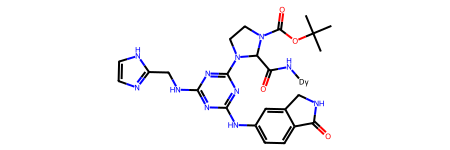

In [40]:
Chem.MolFromSmiles('CC(C)(C)OC(=O)N1CCN(c2nc(NCc3ncc[nH]3)nc(Nc3ccc4c(c3)CNC4=O)n2)C1C(=O)N[Dy]')

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [48]:
sample

,molecule_smiles
0,C#CC[C@H](Nc1nc(NCCC2CC(=O)N(C)C2)nc(Nc2ccc(-n...
1,C#CC[C@H](Nc1nc(NCC2CCC3(CC3)CN2C)nc(Nc2ccc(-n...
2,C#CC[C@H](Nc1nc(Nc2ccc(-n3cccc3)cc2)nc(Nc2csc(...
3,C#CC[C@H](Nc1nc(Nc2ccc(-n3cccc3)cc2)nc(Nc2cc(O...
4,C#CC[C@H](Nc1nc(Nc2ccc(-n3cccc3)cc2)nc(Nc2ccoc...
...,...
9995,C=CCC(CC=C)(Nc1nc(NCc2ccccc2CN(C)Cc2ccco2)nc(N...
9996,C=CCC(CC=C)(Nc1nc(NCCC2CC(=O)N(C)C2)nc(Nc2cc(O...
9997,C=CCC(CC=C)(Nc1nc(NCCCOCOC)nc(Nc2cc(OC)ccc2OC)...
9998,C=CCC(CC=C)(Nc1nc(NCC(c2ccc(OC)c(OC)c2)N2CCOCC...


In [81]:
import random
sample = con.query(f"""(SELECT * FROM parquet_scan('{paths.TRAIN_PATH}') USING SAMPLE 10000 ROWS)""").df()
mols_bb1 = [Chem.MolFromSmiles(s) for s in sample['buildingblock1_smiles'].values.tolist()]
mols_bb2 = [Chem.MolFromSmiles(s) for s in sample['buildingblock2_smiles'].values.tolist()]
mols_bb3 = [Chem.MolFromSmiles(s) for s in sample['buildingblock3_smiles'].values.tolist()]
mols = [Chem.MolFromSmiles(s) for s in sample['molecule_smiles'].values.tolist()]

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

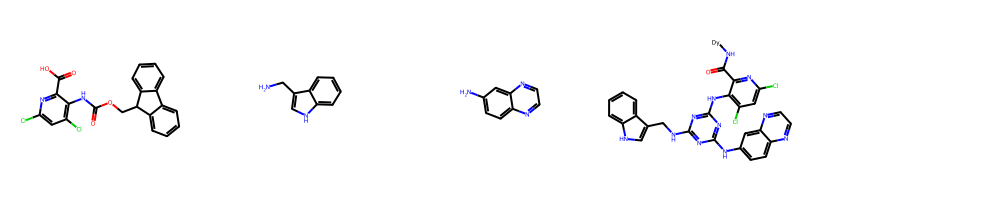

In [145]:
i = random.randint(0, len(mols_bb1))
mols_list = [mols_bb1[i], mols_bb2[i], mols_bb3[i], mols[i]]
img = Draw.MolsToGridImage(mols_list,
molsPerRow=5, #一列に配置する分子の数
subImgSize=(200,200),
)
img

In [ ]:
sample = con.query(f"""(SELECT * FROM parquet_scan('{paths.TRAIN_PATH}') LIMIT 10)""").df()
sample.head()